# Image Caption Generator

## Introduction

Caption generation is a challenging artificial intelligence problem where a textual description must be generated for a given photograph.

It requires both methods from computer vision to understand the content of the image and a language model from the field of natural language processing to turn the understanding of the image into words in the right order.

## Dataset

We will be using the Flickr8k Dataset for our project.

It contains around 8091 images and 5 captions for each image (5 * 8091 = 40455 captions)

Dataset Source: KAGGLE LINK https://www.kaggle.com/shadabhussain/flickr8k

## Model Evaluation matrix

BLEU (Bilingual Evaluation Understudy)

BLEU is a metric for evaluating a generated sentence to a reference sentence. A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.

The approach works by counting matching n-grams in the candidate translation to n-grams in the reference text, where 1-gram or unigram would be each token and a bigram comparison would be each word pair. The comparison is made regardless of word order.

*The Python Natural Language Toolkit library, or NLTK, provides an implementation of the BLEU score that you can use to evaluate your generated text against a reference.*

### Importing necessary libraries

In [1]:
import tensorflow as tf
import keras
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
from collections import Counter
warnings.filterwarnings("ignore")
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))

# Configuring gpu for notebook
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "0"
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))


def set_seed(sd=123):
    from numpy.random import seed
    from tensorflow import set_random_seed
    import random as rn
    ## numpy random seed
    seed(sd)
    ## core python's random number 
    rn.seed(sd)
    ## tensor flow's random number
    set_random_seed(sd)

python 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
keras version 2.8.0
tensorflow version 2.8.0



### Downloading and importing dataset in the notebook

In [2]:
## The location of the Flickr8K_ photos
dir_Flickr_jpg = "img_Dataset"
## The location of the caption file
dir_Flickr_text = "Data_text\Flickr8k.token.txt"

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs)))

The number of jpg flies in Flicker8k: 8091


## Preliminary Analysis

#### Importing Caption data

Load the text data and save it into a panda dataframe df_txt.

In [3]:
## read in the Flickr caption data
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()


datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])


uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")

# Counting number of captions for each image using counter
Counter(Counter(df_txt.filename.values).values())

The number of unique file names : 8092
The distribution of the number of captions for each image:


Counter({5: 8092})

In [4]:
df_txt[:6]

,filename,index,caption
0,1000268201_693b08cb0e.jpg,0,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,1,a girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,2,a little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,3,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,4,a little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,0,a black dog and a spotted dog are fighting


### Example pictures with captions

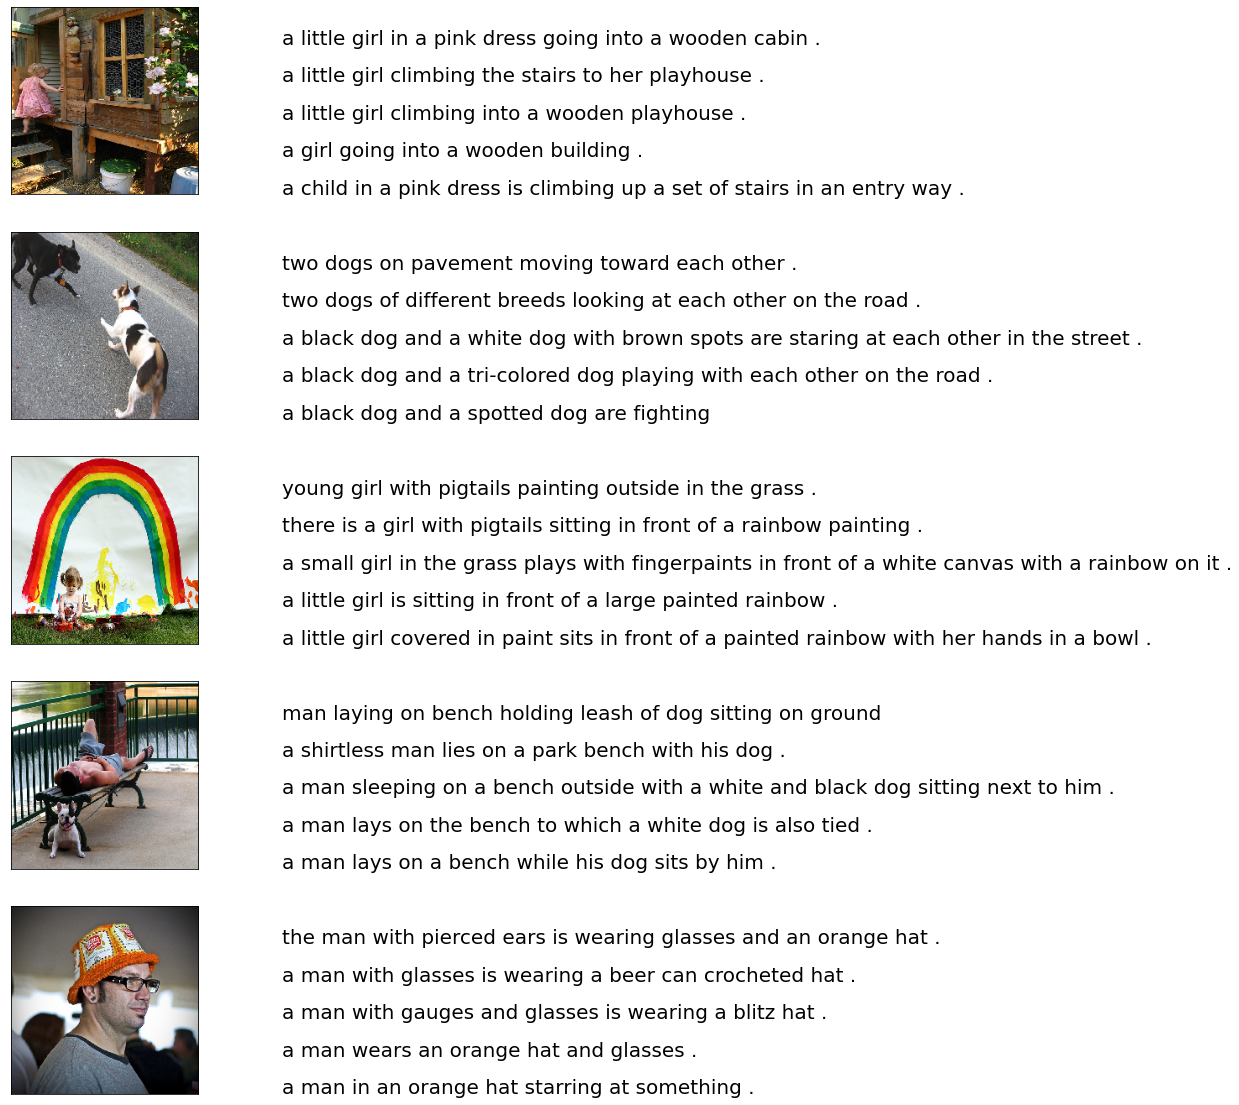

In [5]:
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Displaying (npic = 5) pics from the dataset
npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[:npic]:
    filename = dir_Flickr_jpg + '/' + jpgfnm
    captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

## Data Preparation

We create a new dataframe dfword to visualize distribution of the words. It contains each word and its frequency in the entire tokens in decreasing order.

In [6]:
def df_word(df_txt):
    vocabulary = []
    for txt in df_txt.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame(list(ct.items()), columns=['word', 'count'])
    dfword.sort_values(by='count', ascending=False, inplace=True)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(df_txt)
dfword.head(3)

Vocabulary Size: 8918


,word,count
0,a,62989
1,.,36581
2,in,18975


#### The most and least frequently appearing words

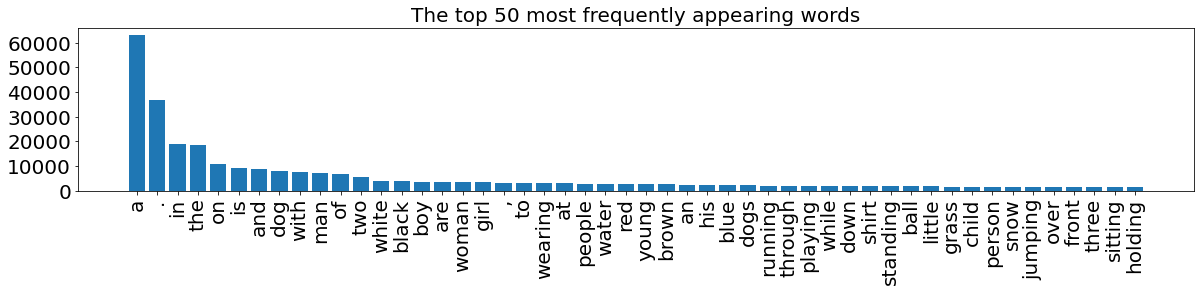

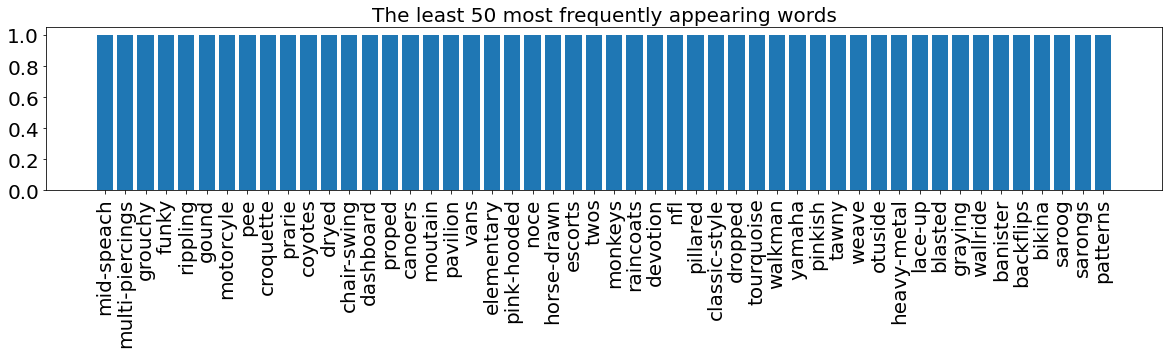

In [7]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

INFERENCE: The most common words are articles such as "a", or "the", or punctuations.

In order to clean the caption, We will create three functions that:

* remove punctuation
* remove single character
* remove numeric characters

###### Cleaning example string using these 3 functions

In [8]:
import string
text_original = "I scored 21 in NLP, but Akshat topped. I have python v3.8. It's 4:20 pm. Could you give us 20 on 20?"

print(text_original)
print("\nRemove punctuations..")
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)
text_no_punctuation = remove_punctuation(text_original)
print(text_no_punctuation)


print("\nRemove a single character word..")
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)
text_len_more_than1 = remove_single_character(text_no_punctuation)
print(text_len_more_than1)

print("\nRemove words with numeric values..")
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)
text_no_numeric = remove_numeric(text_len_more_than1,printTF=True)
print(text_no_numeric)

I scored 21 in NLP, but Akshat topped. I have python v3.8. It's 4:20 pm. Could you give us 20 on 20?

Remove punctuations..
I scored 21 in NLP but Akshat topped I have python v38 Its 420 pm Could you give us 20 on 20

Remove a single character word..
 scored 21 in NLP but Akshat topped have python v38 Its 420 pm Could you give us 20 on 20

Remove words with numeric values..
    scored     : True
    21         : False
    in         : True
    NLP        : True
    but        : True
    Akshat     : True
    topped     : True
    have       : True
    python     : True
    v38        : False
    Its        : True
    420        : False
    pm         : True
    Could      : True
    you        : True
    give       : True
    us         : True
    20         : False
    on         : True
    20         : False
 scored in NLP but Akshat topped have python Its pm Could you give us on


### Cleaning all captions in dataset

Using the 3 functions, we will clean all captions

In [9]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)


for i, caption in enumerate(df_txt.caption.values):
    newcaption = text_clean(caption)
    df_txt["caption"].iloc[i] = newcaption

After cleaning our vocabulary size is significantly reduced by around 200 words.

#### Now, after cleaning the caption list of 50 most occurring and least occurring words

Vocabulary Size: 8763


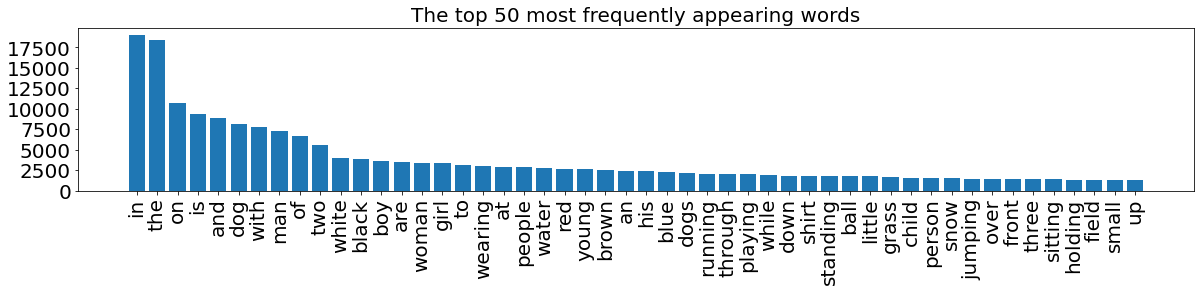

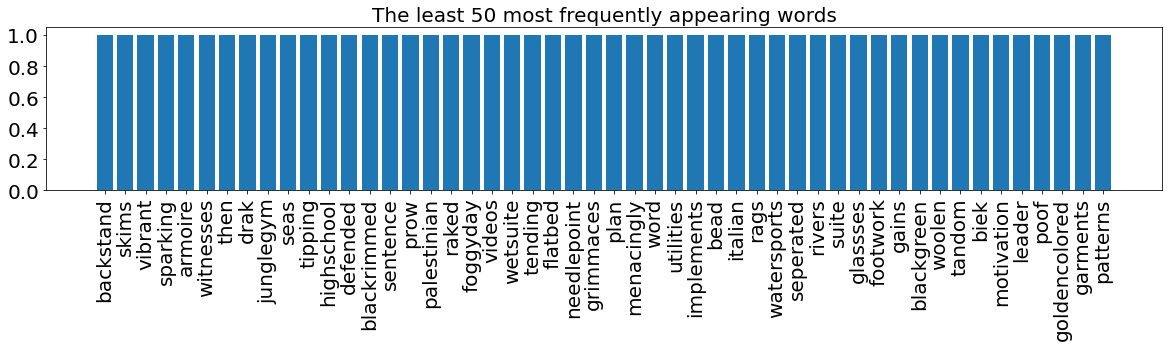

In [10]:
dfword = df_word(df_txt)
plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

### Adding Start and End sequence tokens in every caption

In [11]:
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_start_end_seq_token(df_txt["caption"])
df_txt0.head(5)
del df_txt

## Image Preparation for the VGG16 Model

We will be using pre-trained network VGG16. This model takes input image of size (224, 224, 3).

We choose this model because it achieves 92.7% (top-5 test accuracy) in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes.

#### Double-click __here__ for the source of Model.

<!--
'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
-->

In [12]:
modelvgg = tf.keras.applications.VGG16(include_top=True, weights=None)
## load the locally saved weights 
modelvgg.load_weights("vgg16_weights_tf_dim_ordering_tf_kernels.h5")
modelvgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

__VGG16 is developed to classify images into 1,000 different classes. As we are not using VGG16 for the sake of the classification but we just need it for extracting features, we will remove the last layer from the network.__

In [13]:
modelvgg.layers.pop()
modelvgg = tf.keras.Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-2].output)
## show the deep learning model
modelvgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Transforming images to features using model

In [14]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict

images = OrderedDict()
npix = 224
target_size = (npix,npix,3)
data = np.zeros((len(jpgs),npix,npix,3))
for i,name in enumerate(jpgs):
    print(i)
    # load an image from file
    filename = dir_Flickr_jpg + '/' + name
    image = load_img(filename, target_size=target_size)
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    nimage = preprocess_input(image)
    
    y_pred = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
    images[name] = y_pred.flatten()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699


5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338


6778
6779
6780
6781
6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977


In [15]:
images['1000268201_693b08cb0e.jpg']

array([2.5076473, 0.       , 0.       , ..., 0.       , 0.       ,
       0.       ], dtype=float32)

In [16]:
len(images)

8091

### Linking the text and image data

In [17]:
dimages, keepindex = [],[]
df_txt0 = df_txt0.loc[df_txt0["index"].values == "0",: ]
for i, fnm in enumerate(df_txt0.filename):
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)
        
fnames = df_txt0["filename"].iloc[keepindex].values
dcaptions = df_txt0["caption"].iloc[keepindex].values
dimages = np.array(dimages)

In [18]:
# 4096 features for all 8091 images

dimages.shape

(8091, 4096)

In [19]:
# List of caption for each image

dcaptions[:5]

array(['startseq  child in pink dress is climbing up set of stairs in an entry way endseq',
       'startseq  black dog and spotted dog are fighting endseq',
       'startseq  little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
       'startseq  man lays on bench while his dog sits by him endseq',
       'startseq  man in an orange hat starring at something endseq'],
      dtype=object)

## Tokenizer

Changing character vector to integer vector/tokens

In [20]:
from keras.preprocessing.text import Tokenizer
## the maximum number of words in dictionary
nb_words = 8000
tokenizer = Tokenizer(nb_words=nb_words)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)

vocabulary size : 4476


In [21]:
# dtexts contains dcaptions but in token/integer form

dtexts[:5]

[[1, 38, 3, 66, 144, 7, 124, 52, 406, 9, 367, 3, 24, 2351, 522, 2],
 [1, 12, 8, 5, 752, 8, 17, 368, 2],
 [1, 48, 15, 170, 3, 584, 101, 3, 41, 9, 551, 1198, 11, 55, 213, 3, 1076, 2],
 [1, 10, 621, 6, 150, 27, 23, 8, 101, 46, 112, 2],
 [1, 10, 3, 24, 82, 96, 1199, 19, 162, 2]]

### Spliting the dataset in training and testing

In [22]:
# We will split the dataset in ratio 6:2:2 (train:valid:test)

prop_test, prop_val = 0.2, 0.2

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

In [23]:
# We need maxlen because keras layer takes input of all the sequences of same length.
# Hence to do the padding we need maximum length in caption

maxlen = np.max([len(text) for text in dtexts])

In [24]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages))
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):

        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()
            out_text = to_categorical(out_text,num_classes = vocab_size)

            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)
# pre-processing is not necessary for testing data
#Xtext_test,  Ximage_test,  ytext_test  = preprocessing(dt_test,di_test)

# captions/images = 4855
 (49631, 30) (49631, 4096) (49631, 4476)
# captions/images = 1618
 (16353, 30) (16353, 4096) (16353, 4476)


In [25]:
# First caption (dt_train[0]) represented in Xtext_train

Xtext_train[:14]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    1],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    1,   75],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    1,   75,   38],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    1,   75,   38,   33],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    1, 

In [26]:
# For each word (49631 words excluding start token) there is a image associated with it
# Image will be same for all words in a caption (i.e. if caption length is 14 Ximage_train[0] = Ximage_train[13])

Ximage_train.shape

(49631, 4096)

In [27]:
# Words one-hot encoding (vocab-size = 4476)

ytext_train.shape

(49631, 4476)

## Model

In [28]:
Ximage_train.shape[1]

4096

In [29]:
from tensorflow.keras import layers
print(vocab_size)
## image feature

dim_embedding = 64

input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256,activation='relu',name="ImageFeature")(input_image)

## sequence model
input_txt = layers.Input(shape=(maxlen,))
### The embedding layer in Keras can be used when we want to create the embeddings to embed higher dimensional data into lower dimensional vector space.
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256,name="CaptionFeature")(ftxt)

## combined model for decoder
decoder = layers.add([ftxt,fimage])
decoder = layers.Dense(256,activation='relu')(decoder)
output = layers.Dense(vocab_size,activation='softmax')(decoder)
model = tf.keras.Model(inputs=[input_image, input_txt],outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

print(model.summary())

4476
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 64)       286464      ['input_3[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 CaptionFeature (LSTM)          (None, 256)          328704      ['embedding[0][0]']              
                                                                                       

__We are giving our model an image and a word (Ximage_train & Xtext_train respectively) and we want it to predict the next word for it which is our target ytext_train__

In [30]:
# Example: Here we are giving one image and a start-word and we want to predict next word.
# The next word is in our target which is 75.

print(Ximage_train[0])
print(Xtext_train[0])
print(ytext_train[0][75])

[2.9835706  0.         0.22122395 ... 0.         0.         0.        ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
1.0


In [31]:
# fit model
start = time.time()

hist = model.fit([Ximage_train, Xtext_train], ytext_train, 
                  epochs=5, verbose=2, 
                  batch_size=64,
                  validation_data=([Ximage_val, Xtext_val], ytext_val))
    
end = time.time()
print("TIME TOOK {:3.2f}MIN".format((end - start )/60))

Epoch 1/5
776/776 - 138s - loss: 5.3195 - val_loss: 4.7609 - 138s/epoch - 178ms/step
Epoch 2/5
776/776 - 137s - loss: 4.3314 - val_loss: 4.4620 - 137s/epoch - 176ms/step
Epoch 3/5
776/776 - 141s - loss: 3.8609 - val_loss: 4.3758 - 141s/epoch - 182ms/step
Epoch 4/5
776/776 - 133s - loss: 3.5452 - val_loss: 4.3985 - 133s/epoch - 171ms/step
Epoch 5/5
776/776 - 132s - loss: 3.2682 - val_loss: 4.5099 - 132s/epoch - 170ms/step
TIME TOOK 11.34MIN


In [32]:
print(Ximage_train.shape,Xtext_train.shape,ytext_train.shape)

(49631, 4096) (49631, 30) (49631, 4476)


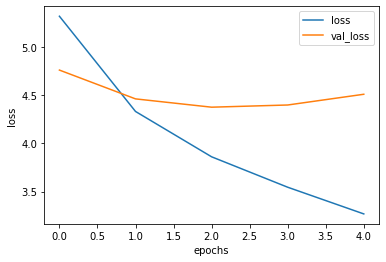

In [33]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

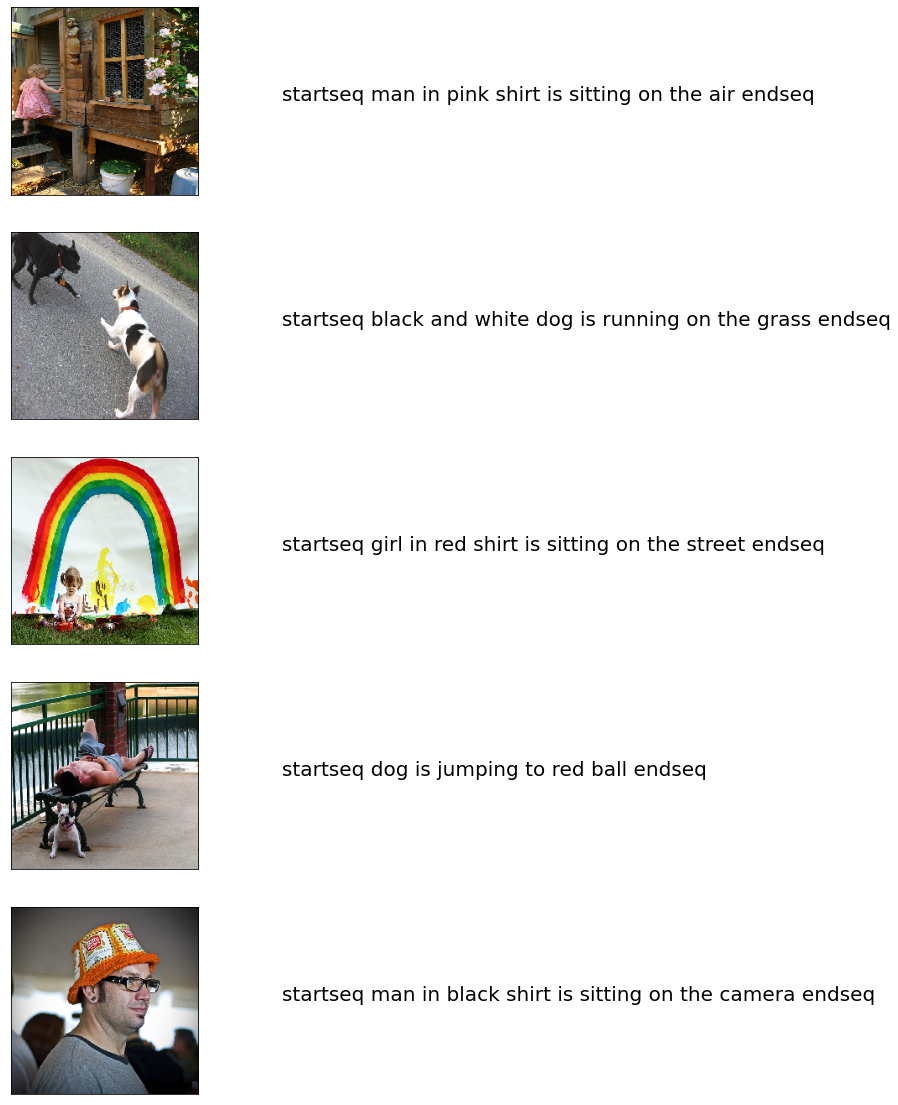

In [34]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption(image):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'startseq'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)



npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[:npic],di_test[:npic]):
    ## images 
    filename = dir_Flickr_jpg + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()

In [35]:
images['1000268201_693b08cb0e.jpg'].shape

(4096,)

## BLEU SCORE

In [36]:
start = time.time()

from nltk.translate.bleu_score import sentence_bleu

index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])


nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 
count = 0 
for jpgfnm, image_feature, tokenized_text in zip(fnm_test,di_test,dt_test):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(fnm_test))))
    
    caption_true = [ index_word[i] for i in tokenized_text ]     
    caption_true = caption_true[1:-1] ## remove startreg, and endreg
    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1]## remove startreg, and endreg
    
    bleu = sentence_bleu([caption_true],caption)
    bleus.append(bleu)
    if bleu > 0.6 and len(pred_good) < nkeep:
        pred_good.append((bleu,jpgfnm,caption_true,caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,jpgfnm,caption_true,caption))
        
end = time.time()
print((start-end)/60)

  12.36% is done..
  24.72% is done..
  37.08% is done..
  49.44% is done..
  61.80% is done..
  74.17% is done..
  86.53% is done..
  98.89% is done..
-11.724073183536529


In [37]:
pred_good

[(0.631914561891573,
  '101654506_8eb26cfb60.jpg',
  ['brown', 'and', 'white', 'dog', 'is', 'running', 'through', 'the', 'snow'],
  ['brown', 'dog', 'is', 'running', 'through', 'the', 'snow']),
 (0.6104735835807844,
  '1119418776_58e4b93eac.jpg',
  ['black', 'and', 'white', 'dog', 'is', 'running', 'through', 'the', 'field'],
  ['black', 'and', 'white', 'dog', 'is', 'running', 'over', 'the', 'grass']),
 (0.6606328636027614,
  '1330645772_24f831ff8f.jpg',
  ['black', 'and', 'white', 'dog', 'is', 'running', 'in', 'the', 'grass'],
  ['black', 'and', 'white', 'dog', 'is', 'running', 'on', 'the', 'grass']),
 (0.7788007830714049,
  '191592626_477ef5e026.jpg',
  ['climber', 'is', 'scaling', 'mountain', 'cliff'],
  ['climber', 'is', 'scaling', 'mountain'])]

In [38]:
pred_bad[:2]

[(3.8667375253680825e-155,
  '1000268201_693b08cb0e.jpg',
  ['child',
   'in',
   'pink',
   'dress',
   'is',
   'climbing',
   'up',
   'set',
   'of',
   'stairs',
   'in',
   'an',
   'entry',
   'way'],
  ['man', 'in', 'pink', 'shirt', 'is', 'sitting', 'on', 'the', 'air']),
 (1.384292958842266e-231,
  '1001773457_577c3a7d70.jpg',
  ['black', 'dog', 'and', 'spotted', 'dog', 'are', 'fighting'],
  ['black', 'and', 'white', 'dog', 'is', 'running', 'on', 'the', 'grass'])]

In [39]:
print("Mean BLEU {:4.3f}".format(np.mean(bleus)))

Mean BLEU 0.011


Bad Caption


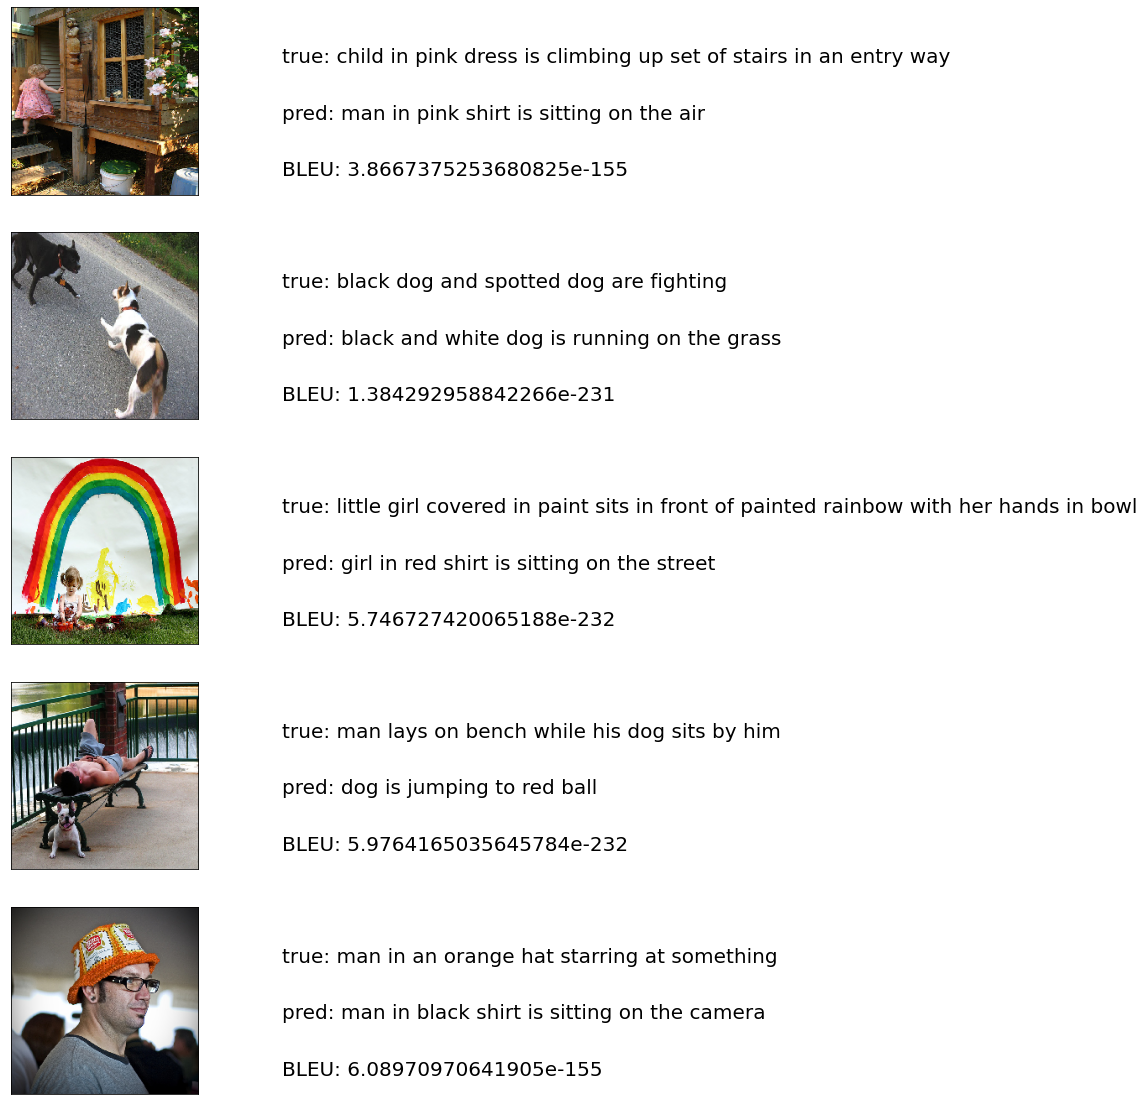

Good Caption


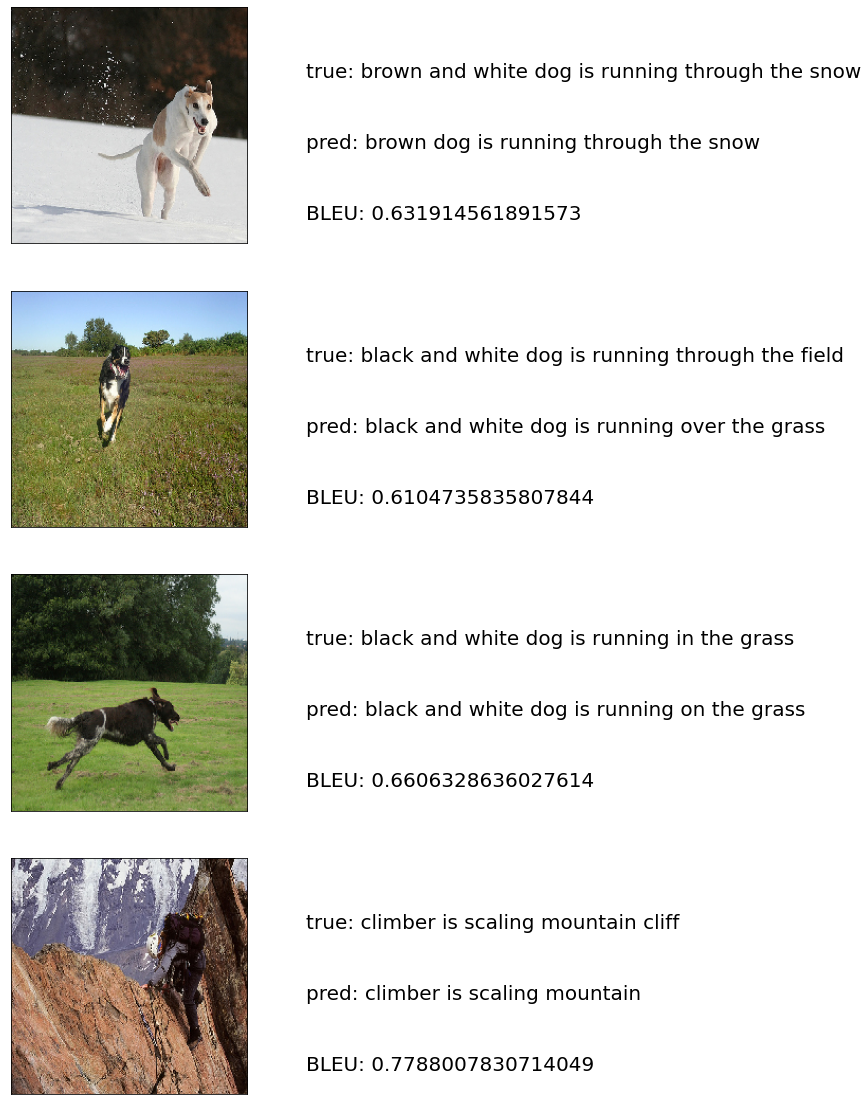

In [40]:
def plot_images(pred_bad):
    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
        return(strue)
    npix = 224
    target_size = (npix,npix,3)    
    count = 1
    fig = plt.figure(figsize=(10,20))
    npic = len(pred_bad)
    for pb in pred_bad:
        bleu,jpgfnm,caption_true,caption = pb
        ## images 
        filename = dir_Flickr_jpg + '/' + jpgfnm
        image_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        caption_true = create_str(caption_true)
        caption = create_str(caption)
        
        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.7,"true:" + caption_true,fontsize=20)
        ax.text(0,0.4,"pred:" + caption,fontsize=20)
        ax.text(0,0.1,"BLEU: {}".format(bleu),fontsize=20)
        count += 1
    plt.show()

print("Bad Caption")
plot_images(pred_bad)
print("Good Caption")
plot_images(pred_good)

## GUI

In [41]:
# Importing libraries

import tkinter as tk
from PIL import Image, ImageTk
from tkinter import filedialog

In [42]:
import os

os.chdir('D:\Vit\Semester 4\Image Processing - CSE4019 - E1 + TE1 - 4 Credits\Project\Project Code')
os.getcwd()

'D:\\Vit\\Semester 4\\Image Processing - CSE4019 - E1 + TE1 - 4 Credits\\Project\\Project Code'

In [43]:
def upload_img():
    global img, image_data
    for img_display in frame.winfo_children():
        img_display.destroy()

    image_data = filedialog.askopenfilename(initialdir="/", title="Choose an image",
                                       filetypes=(("all files", "*.*"), ("png files", "*.png")))
    basewidth = 300
    img = Image.open(image_data)
    wpercent = (basewidth / float(img.size[0]))
    hsize = int((float(img.size[1]) * float(wpercent)))
    img = img.resize((basewidth, hsize), Image.ANTIALIAS)
    img = ImageTk.PhotoImage(img)
    file_name = image_data.split('/')
    panel = tk.Label(frame, text= str(file_name[len(file_name)-1]).upper()).pack()
    panel_image = tk.Label(frame, image=img).pack()
    
def caption():
    
    original = Image.open(image_data)
    original = original.resize((224, 224), Image.ANTIALIAS)
    numpy_image = img_to_array(original)
    nimage = preprocess_input(numpy_image)
    
    feature = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
    caption = predict_caption(feature)
    table = tk.Label(frame, text="Caption: " + caption[9:-7], font=("Helvetica", 12)).pack()

In [47]:
root = tk.Tk()
root.title('IMAGE CAPTION GENERATOR')
#root.iconbitmap('class.ico')
root.resizable(False, False)
tit = tk.Label(root, text="IMAGE CAPTION GENERATOR", padx=25, pady=6, font=("", 12)).pack()
canvas = tk.Canvas(root, height=550, width=600, bg='#D1EDf2')
canvas.pack()
frame = tk.Frame(root, bg='white')
frame.place(relwidth=0.8, relheight=0.8, relx=0.1, rely=0.1)
chose_image = tk.Button(root, text='Choose Image',
                        padx=35, pady=10,
                        fg="black", bg="pink", command=upload_img, activebackground="#add8e6")
chose_image.pack(side=tk.LEFT)

caption_image = tk.Button(root, text='Classify Image',
                        padx=35, pady=10,
                        fg="black", bg="pink", command=caption, activebackground="#add8e6")
caption_image.pack(side=tk.RIGHT)
root.mainloop()

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "C:\Users\Lenovo\AppData\Local\Temp/ipykernel_2512/1523009455.py", line 16, in upload_img
    panel_image = tk.Label(frame, image=img).pack()
  File "C:\Users\Lenovo\anaconda3\lib\tkinter\__init__.py", line 3148, in __init__
    Widget.__init__(self, master, 'label', cnf, kw)
  File "C:\Users\Lenovo\anaconda3\lib\tkinter\__init__.py", line 2572, in __init__
    self.tk.call(
_tkinter.TclError: image "pyimage1" doesn't exist
